332
314
50


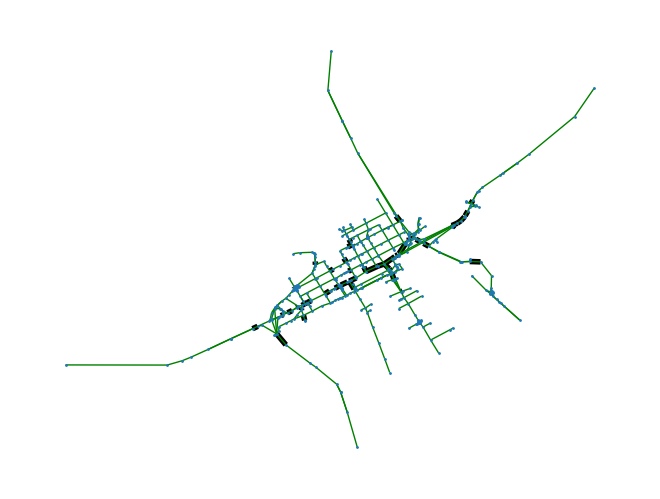

In [5]:
import sumolib
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import random

import torch
import torch_geometric
import torch_geometric.data as Data
import torch_geometric.utils as pyg_utils

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import json
import sys
import import_ipynb
%run ./Data_handling.ipynb
%run ./Data_visualization.ipynb
%run ./Model.ipynb
%run ./Analysis.ipynb

## Data handling

In [2]:
G1 = read_sumo_net1('../Data/s_gyor.net.xml') # type: ignore
#G2 = add_edge_features_from_xml(G1,'../Data/gyor_forg_15_min.xml',"0.00")
#pyg_data = nx_to_pyg(G2)

In [6]:
G2 = add_edge_features_from_xml(G1,'../Data/gyor_forg_15_min.xml',"10800.00")
data = torch.load('../Data/data.pth')
edges_to_hide = choose_hidden_edges_well(data, '../Data/s_gyor.net.xml', 3, 7, 0.3, 150)
print(len(edges_to_hide))

354


## Initialization of the model

In [9]:
G2 = add_edge_features_from_xml(G1,'../Data/gyor_forg_15_min.xml',"10800.00")
#with open('../Data/edges_to_hide.json', 'r') as file:
#    edges_to_hide = json.load(file)
data = torch.load('../Data/data.pth')

prepared_training_data, prepared_test_data, summa = data_preparation(data, edges_to_hide,False)
print(summa)


# Define the model
edge_dim = 1  # Number of edge features
hidden_dim1 = 32
hidden_dim2 = 128
hidden_dim3 = 64
hidden_dim4 = 32
hidden_dim5 = 32
hidden_dim6 = 32
hidden_dim7 = 32
hidden_dim8 = 32

model = GNN(edge_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, hidden_dim7, hidden_dim8)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

training_the_model(model, optimizer, criterion, 2000, prepared_test_data, prepared_training_data, edges_to_hide, 20)

#with open('total_losses.json', 'w') as file:
#    json.dump(total_losses, file)
#with open('losses.json', 'w') as file:
#    json.dump(losses, file)

tensor(0.0980)
Epoch 1, Loss: 0.04907703027129173
Epoch 21, Loss: 0.05127832293510437
Epoch 41, Loss: 0.055037133395671844
Epoch 61, Loss: 0.052702099084854126
Epoch 81, Loss: 0.05372687429189682
Epoch 101, Loss: 0.06581281870603561
Epoch 121, Loss: 0.05007333308458328
Epoch 141, Loss: 0.0495833158493042
Epoch 161, Loss: 0.05410226061940193
Epoch 181, Loss: 0.052827849984169006
Epoch 201, Loss: 0.04575381428003311
Epoch 221, Loss: 0.047682758420705795
Epoch 241, Loss: 0.051365625113248825
Epoch 261, Loss: 0.0675138309597969
Epoch 281, Loss: 0.0529412217438221
Epoch 301, Loss: 0.046540454030036926
Epoch 321, Loss: 0.055864036083221436
Epoch 341, Loss: 0.03991028293967247
Epoch 361, Loss: 0.057805318385362625
Epoch 381, Loss: 0.05065003037452698
Epoch 401, Loss: 0.05133810266852379
Epoch 421, Loss: 0.043957799673080444
Epoch 441, Loss: 0.04948998615145683
Epoch 461, Loss: 0.04711819067597389
Epoch 481, Loss: 0.05162503570318222
Epoch 501, Loss: 0.04329485446214676
Epoch 521, Loss: 0.0498

([0.04907703027129173,
  0.053427793085575104,
  0.05464911088347435,
  0.05751969292759895,
  0.04945967718958855,
  0.04802268370985985,
  0.045134287327528,
  0.04047978296875954,
  0.047397833317518234,
  0.05631042644381523,
  0.0489434078335762,
  0.05908127874135971,
  0.0521060936152935,
  0.045017845928668976,
  0.04515988007187843,
  0.04736996814608574,
  0.0530630461871624,
  0.051529016345739365,
  0.050105489790439606,
  0.04684431478381157,
  0.05127832293510437,
  0.0686454251408577,
  0.0571092814207077,
  0.0550803542137146,
  0.04811253398656845,
  0.048336707055568695,
  0.05600930377840996,
  0.04768700897693634,
  0.0557701475918293,
  0.052509140223264694,
  0.05420316755771637,
  0.050115764141082764,
  0.0519876591861248,
  0.054612740874290466,
  0.046019844710826874,
  0.05228958651423454,
  0.04991224780678749,
  0.050018131732940674,
  0.04629909247159958,
  0.05164875462651253,
  0.055037133395671844,
  0.046250246465206146,
  0.039889369159936905,
  0.049

In [65]:
torch.save(model.state_dict(), 'gnn_model_ces.pth')
#cep : change every step
layers = [model.conv1, model.conv2, model.conv3, model.conv4, model.conv5, model.conv6, model.conv7, model.conv8]
edge_dims = []
for layer in layers:
    edge_dims.append(layer.in_channels)
edge_dims.append(model.linear.in_features)
with open('dimensions.json','w') as file:
    json.dump(edge_dims, file)


## Loading the model
Once we trained it nd saved it, this is how we can load it

In [66]:
with open('edges_to_hide.json', 'r') as file:
    edges_to_hide = json.load(file)
data = torch.load('data.pth')

prepared_training_data, prepared_test_data, summa = data_preparation(data, edges_to_hide)

with open('dimensions.json', 'r') as file:
    edge_dims = json.load(file)

model2 = GNN(edge_dims[0], edge_dims[1], edge_dims[2], edge_dims[3], edge_dims[4], edge_dims[5], edge_dims[6], edge_dims[7], edge_dims[8])
model2.load_state_dict(torch.load('gnn_model_ces.pth'))
output = model2(prepared_training_data[3].edge_attr, prepared_training_data[3].edge_index)



<All keys matched successfully>

## Data visualization